In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Helper functions for plotting.
def palette(num):
    if num == 2:
        return ['#addd8e', '#31a354']
    elif num == 3:
        return ['#c2e699', '#78c679', '#238443']
    elif num == 4:
        return  ['#c2e699', '#78c679', '#31a354', '#006837']
    
def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        (before, after) = costs[:i], costs[i+1:]
        # All points such that there is no point which has at least one objective minimized better and other objectives at least equal.
        is_efficient[i] = np.all(np.logical_not(np.logical_and(np.all(before <= c, axis=1), np.any(before < c, axis=1)))) and \
                          np.all(np.logical_not(np.logical_and(np.all(after <= c, axis=1), np.any(after < c, axis=1))))
    return is_efficient

In [3]:
# Benchmark files
csv_files = ['md-knn-summary', 'md-grid-summary', 'stencil2d-inner-summary']

# Dataframes with all the data.
dfs = { bench_name : pd.read_csv(f"data/{bench_name}.csv") for bench_name in csv_files }

# Calculate average latencies for each benchmark.
for key in csv_files:
    dfs[key]['avg_latency'] = ((dfs[key]['min_latency'] + dfs[key]['max_latency']) /  2)

In [4]:
resources = ['bram_used', 'dsp48_used', 'ff_used', 'lut_used', 'avg_latency']

# sns.set()
def lut_res_plot(
    data, 
    keys, 
    to_save=None, 
    name="", 
    legend="xxx", 
    both=False, 
    xproc=lambda x: int(x / 10 ** 3), 
    xlabel='thousands of ', 
    title='XXX', 
    show_title=False):
    
    opts = find_pareto(data[resources].to_numpy())
    pareto = data.iloc[opts]
    print(f"[Qualitative Study] Number of pareto points for {name}: {len(pareto)}/{len(data)}")

    for key in keys:
        num = len(data[key].unique())
#         pal = palette(num)
        pal = sns.color_palette('cubehelix_r', num)
        fig = plt.figure()
        plt.grid()
        ax = fig.gca()
        for idx, val in enumerate(sorted(data[key].unique())):
#             if both: 
#                 sns.scatterplot(x='avg_latency', y='lut_used', data=pareto[pareto[key] == val], rasterized=True, color=pal[idx])

            sns.scatterplot(x='avg_latency', y='lut_used', data=pareto[pareto[key] == val], rasterized=True, label=str(val), color=pal[idx], ax=ax, s=110)
        if key != to_save:
            ax.legend(title=key, fontsize=13)
        else:
            ax.legend(title=legend, fontsize=13).set_title(legend, prop={'size':14})
        ax.set_title(title)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(xproc(x), ',')))
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.set_xlabel(f'Estimated latency ({xlabel}cycles)', fontsize=13)
        if show_title:
            ax.set_ylabel('Estimate LUTs', fontsize=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(labelsize=11)
        if key == to_save:
            print(name)
            fig.savefig(f'dahlia-dse-{name}.pdf', dpi=600, tight_layout=True)

[Qualitative Study] Number of pareto points for stencil2d-inner: 8/18
stencil2d-inner


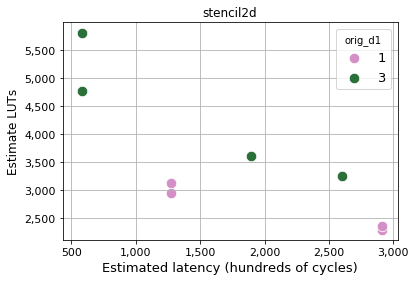

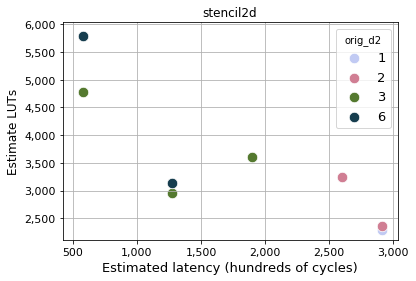

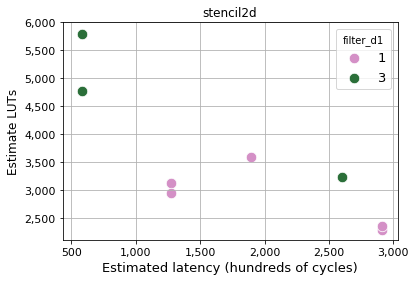

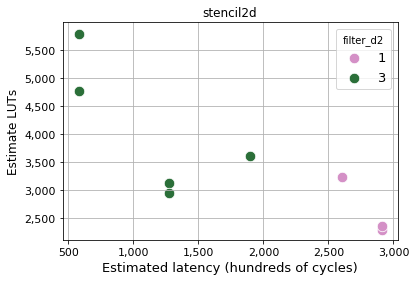

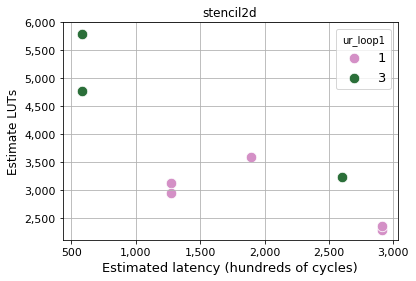

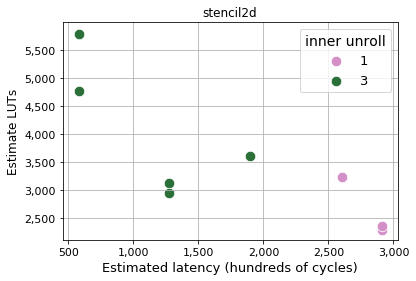

In [5]:
def plot_stencil2d():
    res = ['orig_d1', 'orig_d2', 'filter_d1', 'filter_d2', 'ur_loop1', 'ur_loop2']
    lut_res_plot(dfs['stencil2d-inner-summary'], 
                 res, 
                 title='stencil2d',
                 to_save='ur_loop2', 
                 legend='inner unroll', 
                 name='stencil2d-inner',
                 xproc=lambda x: int(x / 100),
                 xlabel="hundreds of ",
                 show_title=True
                )

plot_stencil2d()

[Qualitative Study] Number of pareto points for md-knn-with-outlier: 50/525
md-knn-with-outlier


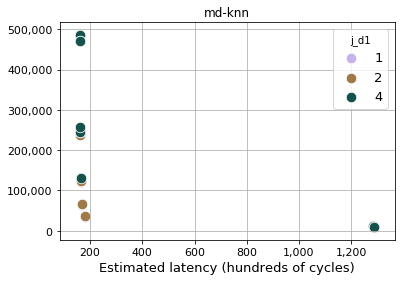

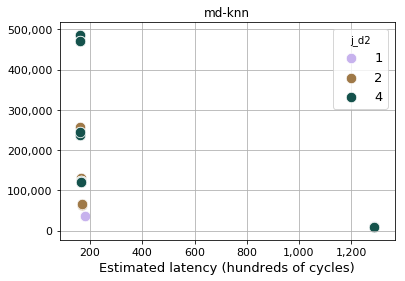

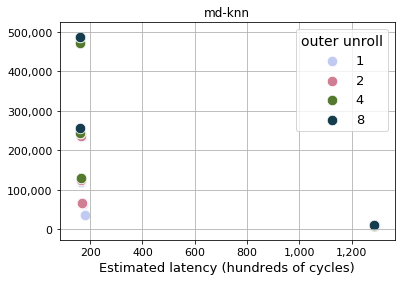

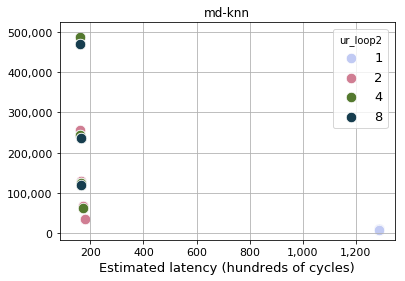

In [6]:
def plot_md_knn_with_outliers():
    res = ['j_d1', 'j_d2', 'ur_loop1', 'ur_loop2']
    df = dfs['md-knn-summary']
    lut_res_plot(df,
                 res, 
                 title='md-knn',
                 to_save='ur_loop1', 
                 legend='outer unroll', 
                 name='md-knn-with-outlier', 
                 both=True,
                 xproc=lambda x: int(x / 100), 
                 xlabel="hundreds of ")
    
plot_md_knn_with_outliers()

## Removing outliers from md_knn

In the graph above, the points on the extreme right trade-off a lot of latency for reducing the LUT count by a bit. In the paper, we decided to not show these points **but we explicitly call this out in the prose**. For the camera-ready, we will attempt to use a broken axis to show the points on the right.

For the submission, we remove the outliers.

[Qualitative Study] Number of pareto points for md-knn: 37/336
md-knn


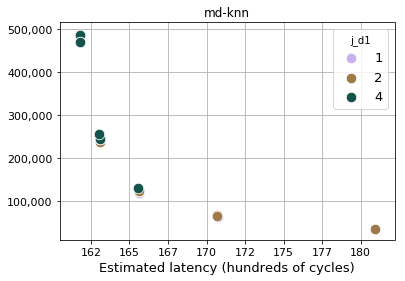

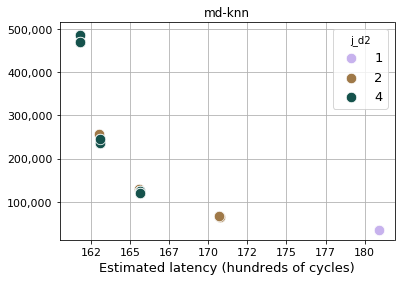

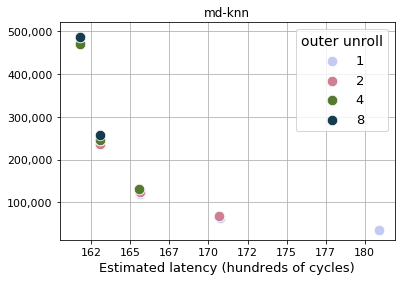

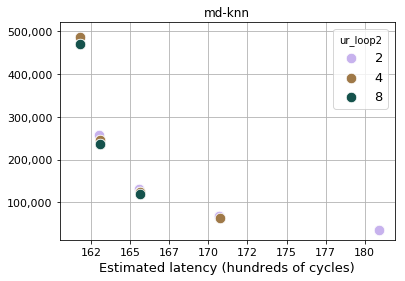

In [7]:
def plot_md_knn_with_outliers():
    res = ['j_d1', 'j_d2', 'ur_loop1', 'ur_loop2']
    df = dfs['md-knn-summary']
    lut_res_plot(df[df.avg_latency < 100000],
                 res, 
                 title='md-knn',
                 to_save='ur_loop1', 
                 legend='outer unroll', 
                 name='md-knn', 
                 both=True,
                 xproc=lambda x: int(x / 100), 
                 xlabel="hundreds of ")
    
plot_md_knn_with_outliers()

[Qualitative Study] Number of pareto points for md-grid: 13/80
md-grid


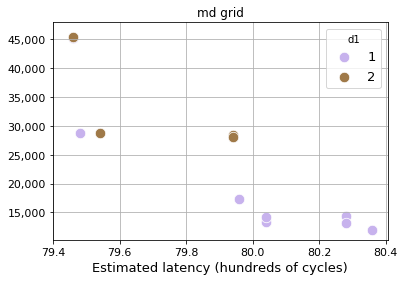

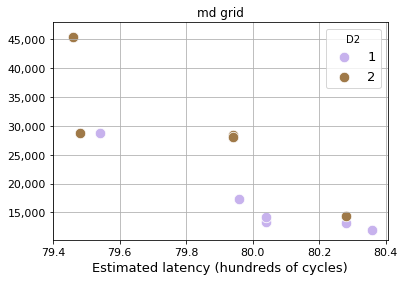

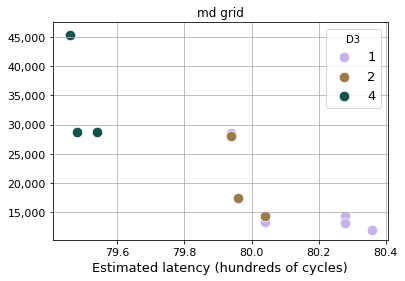

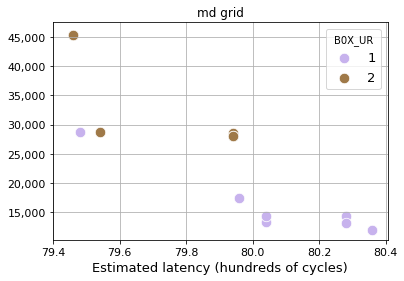

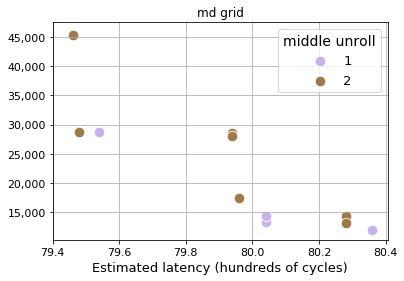

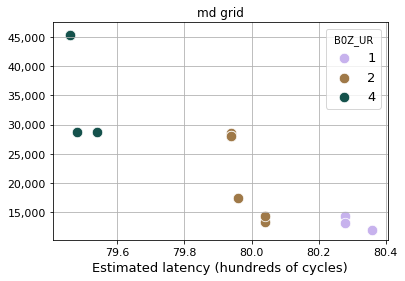

In [8]:
def plot_md_grid():
    res = ['d1', 'D2', 'D3', 'B0X_UR', 'B0Y_UR', 'B0Z_UR']
    lut_res_plot(dfs['md-grid-summary'], 
                 res, 
                 name='md-grid',
                 title='md grid',
                 to_save='B0Y_UR', 
                 legend='middle unroll', 
                 both=True, 
                 xproc=lambda x: x / 100, 
                 xlabel='hundreds of ')
    
plot_md_grid()

In [9]:
data = dfs['md-knn-summary']
print(len(data[data.avg_latency > 120000]))
print(len(data[data.avg_latency < 120000]))


# opts = find_pareto(data[resources].to_numpy())
# pareto = data.iloc[opts]
# len(data[data.avg_latency < 120000])

189
336
